# Survival prediction

In [144]:
# Import libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn import tree
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold,cross_val_score,train_test_split
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

In [145]:
with open('train_titanic.csv', 'r') as f:
    for i, line in zip(range(5), f):
        print(line.strip())

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S


In [188]:
train = pd.read_csv('train_titanic.csv')
test = pd.read_csv('test_titanic.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [155]:
X = train
y = train.pop("Survived")

In [156]:
# Check for missing values
X.count()

PassengerId    891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

#### Missing values in Age

In [157]:
# Impute missing values
X["Age"].fillna(X.Age.mean(), inplace = True)

In [158]:
X.count()

PassengerId    891
Pclass         891
Name           891
Sex            891
Age            891
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

#### Taking only numeric variables to start with

In [159]:
numeric_features = X[['Fare', 'Pclass', 'Age']]

In [160]:
median_features = numeric_features.dropna().median()
imputed_features = numeric_features.fillna(median_features)
features_array = imputed_features.values

In [161]:
from sklearn.cross_validation import train_test_split

features_train, features_test, target_train, target_test = train_test_split(
    features_array, y, test_size=0.20, random_state=0)

In [162]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1)
logreg.fit(numeric_features, y)
target_predicted = logreg.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy_score(target_test, target_predicted)

0.73743016759776536

In [163]:
rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, oob_score= True,n_jobs=-1, random_state = 32)
rf.fit(numeric_features,y)
target_predicted = rf.predict(features_test)
from sklearn.metrics import accuracy_score
accuracy_score(target_test, target_predicted)

0.86592178770949724

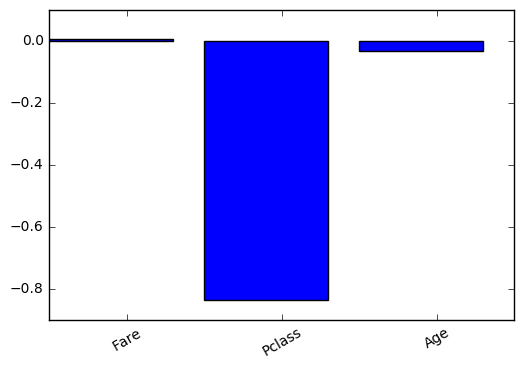

In [164]:
feature_names = numeric_features.columns
x = np.arange(len(feature_names))
plt.bar(x, logreg.coef_.ravel())
plt.xticks(x + 0.5, feature_names, rotation=30);

In [165]:
rf.feature_importances_

array([ 0.48555556,  0.15005136,  0.36439308])

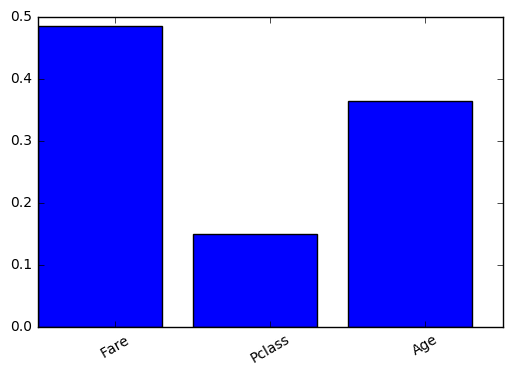

In [166]:
feature_names = numeric_features.columns.values
x = np.arange(len(feature_names))
plt.bar(x, rf.feature_importances_)
_ = plt.xticks(x + 0.5, feature_names, rotation=30)


In [167]:
pd.get_dummies(X['Sex'], prefix='Sex').head(5)

,Sex_female,Sex_male
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,0.0,1.0


In [168]:
pd.get_dummies(data.Embarked, prefix='Emb').head(5)

,Emb_C,Emb_Q,Emb_S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


In [205]:
new_features = pd.concat([X[['Fare', 'Pclass', 'Age']],
                           pd.get_dummies(X['Sex'], prefix='Sex'),
                           pd.get_dummies(X['Embarked'], prefix='Embarked')],
                          axis=1)
new_features.head(5)

,Fare,Pclass,Age,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,7.2500,3,22.0,0.0,1.0,0.0,0.0,1.0
1,71.2833,1,38.0,1.0,0.0,1.0,0.0,0.0
2,7.9250,3,26.0,1.0,0.0,0.0,0.0,1.0
3,53.1000,1,35.0,1.0,0.0,0.0,0.0,1.0
4,8.0500,3,35.0,0.0,1.0,0.0,0.0,1.0


In [206]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

logreg = LogisticRegression(C=1)
scores = cross_val_score(logreg, new_features, y, cv=5, scoring='accuracy')
print("Logistic Regression CV scores:")
print("min: {:.3f}, mean: {:.3f}, max: {:.3f}".format(
    scores.min(), scores.mean(), scores.max()))

Logistic Regression CV scores:
min: 0.775, mean: 0.788, max: 0.810
Wall time: 33 ms


In [207]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

logreg = LogisticRegression(C=0.00001)
scores = cross_val_score(logreg, new_features, y, cv=5, scoring='accuracy')
print("Logistic Regression CV scores:")
print("min: {:.3f}, mean: {:.3f}, max: {:.3f}".format(
    scores.min(), scores.mean(), scores.max()))

Logistic Regression CV scores:
min: 0.598, mean: 0.676, max: 0.743
Wall time: 24 ms


In [208]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

logreg = LogisticRegression(C=2)
scores = cross_val_score(logreg, new_features, y, cv=5, scoring='accuracy')
print("Logistic Regression CV scores:")
print("min: {:.3f}, mean: {:.3f}, max: {:.3f}".format(
    scores.min(), scores.mean(), scores.max()))

Logistic Regression CV scores:
min: 0.775, mean: 0.787, max: 0.810
Wall time: 31 ms


In [272]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(logreg, features_array, target, cv=5)
scores.min(), scores.mean(), scores.max()

(0.63128491620111726, 0.70044212559317431, 0.7584269662921348)

In [263]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, new_features, y, cv=5, n_jobs=4,
                         scoring='accuracy')
print("Random Forest CV scores:")
print("min: {:.3f}, mean: {:.3f}, max: {:.3f}".format(
    scores.min(), scores.mean(), scores.max()))

Random Forest CV scores:
min: 0.782, mean: 0.813, max: 0.854
Wall time: 2.85 s


In [273]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(rf, features_array, target, cv=5)
scores.min(), scores.mean(), scores.max()

(0.62011173184357538, 0.6622644901902166, 0.7247191011235955)

In [264]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                subsample=.8, max_features=.5)
scores = cross_val_score(gb, new_features, y, cv=5, n_jobs=4,
                         scoring='accuracy')
print("Gradient Boosted Trees CV scores:")
print("min: {:.3f}, mean: {:.3f}, max: {:.3f}".format(
    scores.min(), scores.mean(), scores.max()))

Gradient Boosted Trees CV scores:
min: 0.799, mean: 0.828, max: 0.864
Wall time: 2.67 s


In [265]:
%%time

from sklearn.grid_search import GridSearchCV

gb = GradientBoostingClassifier(n_estimators=1000, subsample=.8)

params = {
    'learning_rate': [0.05, 0.1, 0.5],
    'max_features': [0.5, 1],
    'max_depth': [3, 4, 5],
}
gs = GridSearchCV(gb, params, cv=5, scoring='roc_auc', n_jobs=4)
gs.fit(new_features, y)

Wall time: 25.7 s


In [266]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)

[mean: 0.87503, std: 0.02506, params: {'max_features': 0.5, 'learning_rate': 0.05, 'max_depth': 3},
 mean: 0.87232, std: 0.02373, params: {'max_features': 0.5, 'learning_rate': 0.1, 'max_depth': 3},
 mean: 0.87220, std: 0.02803, params: {'max_features': 1, 'learning_rate': 0.1, 'max_depth': 3},
 mean: 0.87107, std: 0.02624, params: {'max_features': 1, 'learning_rate': 0.05, 'max_depth': 3},
 mean: 0.86540, std: 0.02559, params: {'max_features': 0.5, 'learning_rate': 0.05, 'max_depth': 4},
 mean: 0.86068, std: 0.03003, params: {'max_features': 1, 'learning_rate': 0.05, 'max_depth': 4},
 mean: 0.86027, std: 0.01922, params: {'max_features': 0.5, 'learning_rate': 0.1, 'max_depth': 4},
 mean: 0.85787, std: 0.02037, params: {'max_features': 0.5, 'learning_rate': 0.05, 'max_depth': 5},
 mean: 0.85707, std: 0.02803, params: {'max_features': 1, 'learning_rate': 0.1, 'max_depth': 4},
 mean: 0.85461, std: 0.01801, params: {'max_features': 1, 'learning_rate': 0.5, 'max_depth': 3},
 mean: 0.85310,

In [267]:
gs.best_score_

0.87502854727852908

In [268]:
gs.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'max_features': 0.5}

In [269]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05,max_depth=3,
                                subsample=.8, max_features=.5)
scores = cross_val_score(gb, new_features, y, cv=5, n_jobs=4,
                         scoring='accuracy')
print("Gradient Boosted Trees CV scores:")
print("min: {:.3f}, mean: {:.3f}, max: {:.3f}".format(
    scores.min(), scores.mean(), scores.max()))

Gradient Boosted Trees CV scores:
min: 0.782, mean: 0.816, max: 0.853


In [274]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(gb, features_array, target, cv=5)
scores.min(), scores.mean(), scores.max()

(0.61452513966480449, 0.71740361949324538, 0.78531073446327682)

In [270]:
gb.fit(new_features, y)
gb.feature_importances_

array([ 0.31104759,  0.12998325,  0.25715413,  0.09203487,  0.1622715 ,
        0.01652818,  0.01816526,  0.01281521])

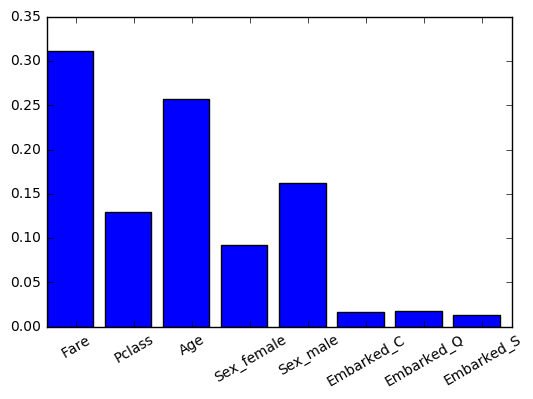

In [271]:
feature_names = new_features.columns.values
x = np.arange(len(feature_names))
plt.bar(x, gb.feature_importances_)
_ = plt.xticks(x + 0.5, feature_names, rotation=30)
